In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tf.enable_eager_execution()

Instructions for updating:
Colocations handled automatically by placer.


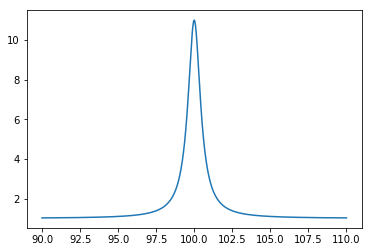

In [3]:
class Model(object):
    def __init__(self):
        '''
        A simple lorentzian
        '''
        self.freq = tf.Variable(100.0)
        self.width_sqr = tf.Variable(1.0)
        self.height = tf.Variable(10.0)
        self.back = tf.Variable(1.0)
        
    def set_params(self, p):
        self.freq, self.width_sqr, self.height, self.back = p
        
    def get_params(self):
        return [self.freq, self.width_sqr, self.height, self.back]
    
    def update_params(self, learning_rate, dfreq, dwidth_sqr, dheight, dback):
        self.freq.assign_sub(learning_rate * dfreq)
        self.width_sqr.assign_sub(learning_rate * dwidth_sqr)
        self.height.assign_sub(learning_rate * dheight)
        self.back.assign_sub(learning_rate * dback)
    
    def __call__(self, f):
        return self.back + self.height / (1.0 + 4.0/self.width_sqr*tf.square(f - self.freq))
    
model = Model()
f = np.linspace(90, 110, 1000)
fig, ax = plt.subplots()
ax.plot(f, model(f))

In [59]:
def loss(Model, Observed):
    return tf.math.reduce_sum(tf.math.log(Model) + Observed/Model)

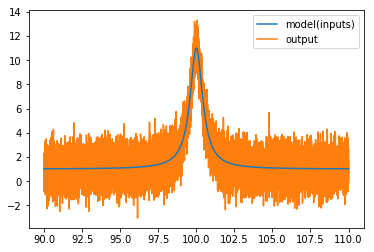

In [79]:
limit_model = Model()
limit_model.set_params([100.0, 1.0, 10.0, 1.0])
inputs = tf.linspace(90.0, 110.0, 10000)
noise = tf.abs((tf.random_normal(shape=inputs.shape) * tf.random_normal(shape=inputs.shape)))
noise = np.random.randn(len(inputs)) * 1.1
outputs = limit_model(inputs) + noise

fig, ax = plt.subplots()
ax.plot(inputs, limit_model(inputs), zorder=99, label='model(inputs)')
ax.plot(inputs, outputs, label='output')
ax.legend()

In [80]:
print(f'Current loss : {loss(model(inputs), outputs).numpy()}')

Current loss : 13442.04296875


In [81]:
def train(model, inputs, outputs, learning_rate, beta=0.9):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dfreq, dwidth_sqr, dheight, dback = t.gradient(current_loss, model.get_params())
  learning_rate *= beta
  model.update_params(learning_rate, dfreq, dwidth_sqr, dheight, dback)

In [82]:
model = Model()

freqs = []
heights = []
backs = []
epochs = range(200)
for epoch in epochs:
    freqs.append(model.freq.numpy())
    heights.append(model.height.numpy())
    backs.append(model.back.numpy())
    current_loss = loss(model(inputs), outputs)
    
    train(model, inputs, outputs, learning_rate=0.001, beta=0.3)
    #print(epoch, freqs[-1], heights[-1], backs[-1], current_loss)


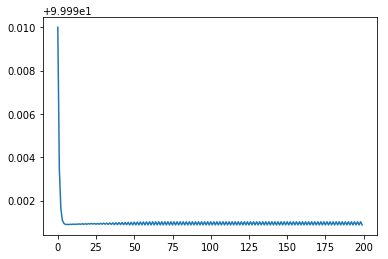

In [83]:
fig, ax = plt.subplots()
ax.plot(epochs, freqs)

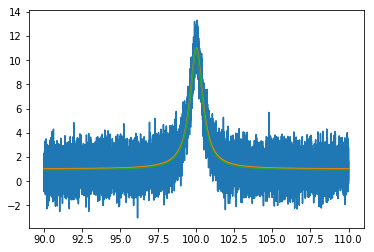

In [84]:
fig, ax = plt.subplots()
ax.plot(inputs, outputs)
ax.plot(inputs, limit_model(inputs))
ax.plot(inputs, model(inputs))